In [1]:
import os

from stable_baselines3 import PPO
from rl4uc.environment import make_env, make_env_from_json

In [2]:
all_rewards = {}
for env_name in ['5gen', '10gen_carbon1', '10gen_carbon2', '10gen'][:1]:
# for env_name in os.listdir('rl4uc/data/envs/'):
    # env_name = env_name.split('.')[0]
    all_rewards[env_name] = {'ppo': [], 'random': []}
    for seed in range(5):
        print(f'env_name: {env_name}, seed: {seed}')
        env = make_env_from_json(env_name, mode='train')
        model = PPO('MultiInputPolicy', env,  seed=seed, verbose=0)
        
        # train
        model.learn(total_timesteps=100000)
        
        # eval - ppo
        for day in range(50):
            env_test = make_env_from_json(env_name, mode='test', day=day)
            obs = env_test.reset()
            while True:
                action, _ = model.predict(obs)
                obs, rew, done, _ = env_test.step(action)
                all_rewards[env_name]['ppo'].append(rew)
                if done:
                    break
            
        # eval - random
            env_test = make_env_from_json(env_name, mode='test', day=day)
            obs = env_test.reset()
            while True:
                action = env_test.action_space.sample()
                obs, rew, done, _ = env_test.step(action)
                all_rewards[env_name]['random'].append(rew)
                if done:
                    break
        
        del model
        del env

env_name: 5gen, seed: 0
env_name: 5gen, seed: 1
env_name: 5gen, seed: 2
env_name: 5gen, seed: 3
env_name: 5gen, seed: 4


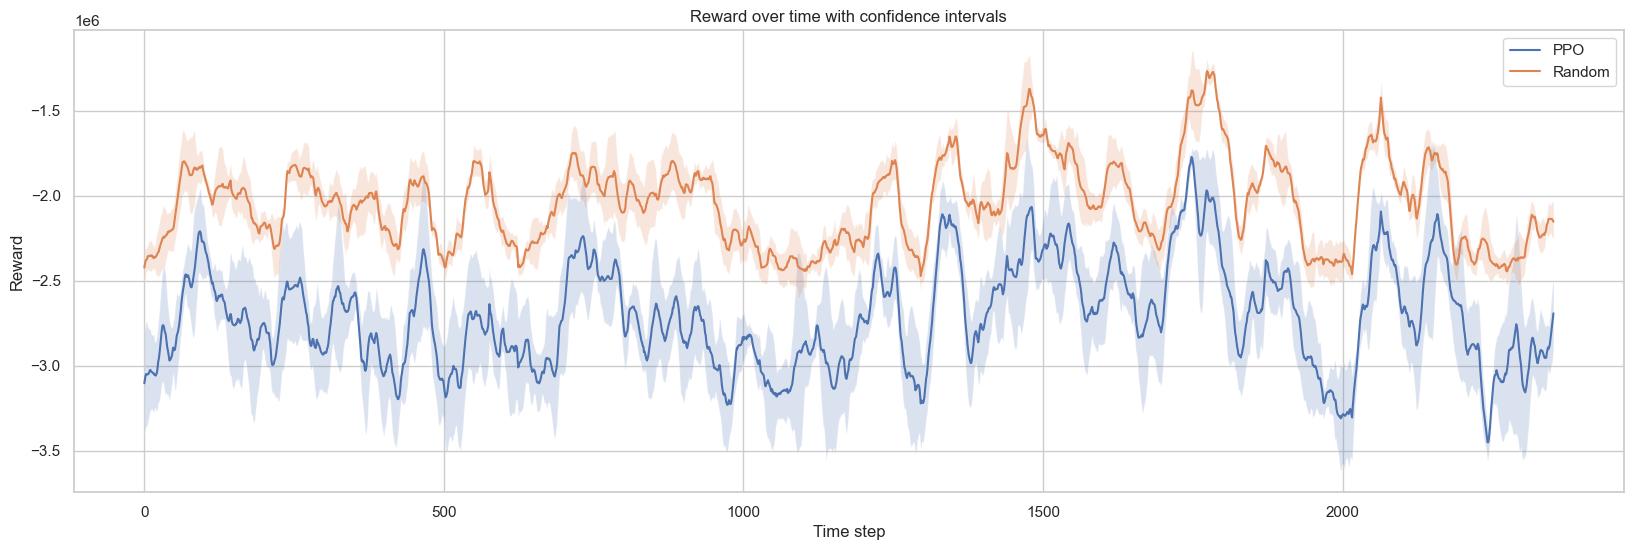

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
for env_name in ['5gen', '10gen_carbon1', '10gen_carbon2', '10gen'][:1]:
    ppo_rew = np.array(all_rewards[env_name]['ppo']).reshape(5, -1)
    random_rew = np.array(all_rewards[env_name]['random']).reshape(5, -1)
    # smoothing on axis 1
    window_size = 48
    ppo_rew_rolling = pd.DataFrame(ppo_rew).rolling(window=window_size, axis=1).mean().values[:, window_size - 1:]
    random_rew_rolling = pd.DataFrame(random_rew).rolling(window=window_size, axis=1).mean().values[:, window_size - 1:]
    T = ppo_rew_rolling.shape[1]
    # mean and std
    mean_ppo = np.mean(ppo_rew_rolling, axis=0)
    std_ppo = np.std(ppo_rew_rolling, axis=0)
    mean_random = np.mean(random_rew_rolling, axis=0)
    std_random = np.std(random_rew_rolling, axis=0)
    # plot with seaborn and do confidence intervals
    sns.set_style("whitegrid")
    ax = sns.lineplot(x=np.arange(T), y=mean_ppo, label="PPO")
    ax.fill_between(np.arange(T), mean_ppo - std_ppo, mean_ppo + std_ppo, alpha=0.2)

    # Add line plot with confidence intervals for rewards2
    sns.lineplot(x=np.arange(T), y=mean_random, label="Random", ax=ax)
    ax.fill_between(np.arange(T), mean_random - std_random, mean_random + std_random, alpha=0.2)

    # Add legend
    ax.legend()

    # Set axis labels and title
    sns.set(rc={"figure.figsize": (20, 6)})
    ax.set_xlabel("Time step")
    ax.set_ylabel("Reward")
    ax.set_title("Reward over time with confidence intervals")
    
    

In [22]:
random_rew_rolling.shape

(5, 2396)

In [25]:
import pandas as pd
import numpy as np
df = pd.DataFrame({'demand': np.array([600., 550., 650.,600.]*12),
			  	   'wind': np.array([10., 50., 70., 40.]*12)})
env = make_env('test', profiles_df=df)
obs = env.reset()
rewards_list = []
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    rewards_list.append(rewards)
    # env.render()
    if dones:
        break
print(np.mean(rewards_list))

-1439024.2931836965


In [29]:
env = make_env('test', profiles_df=df)
obs = env.reset()
while True:
    action = np.random.randint(0, 2, size=5)
    obs, rewards, dones, info = env.step(action)
    rewards_list.append(rewards)
    # env.render()
    if dones:
        break
print(np.mean(rewards_list))

-1163600.0654844588
